<a href="https://colab.research.google.com/github/Davidportlouis/denoising_images/blob/master/denoising_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import torch
import numpy as np
from torch import nn,optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
def plot_batch(img_batch,labels):
  fig = plt.figure(figsize=(20,4))
  for idx in range(len(img_batch)):
    ax = fig.add_subplot(2,len(img_batch)/2,idx+1,xticks=[],yticks=[])
    ax.imshow(img_batch[idx].numpy().squeeze(),cmap="gray")
    ax.set_title(f"Class: {classes[labels[idx].item()]}")

transform = transforms.ToTensor()

In [11]:
train_data = datasets.FashionMNIST(root="./",train=True,transform=transform,download=True)
test_data = datasets.FashionMNIST(root="./",train=False,transform=transform,download=True)
trainloader = DataLoader(train_data,batch_size=20,shuffle=True)
testloader = DataLoader(test_data,batch_size=20,shuffle=True)
classes = train_data.classes

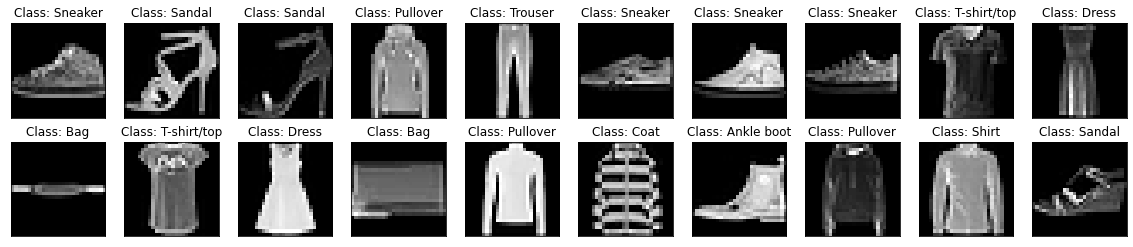

In [12]:
train_imgs,train_labels = next(iter(trainloader))
plot_batch(train_imgs,train_labels)

In [4]:
class ConvDenoiser(nn.Module):
  def __init__(self):
    super(ConvDenoiser,self).__init__()
    ## Encoder layers
    self.conv_1 = nn.Conv2d(1,64,3,padding=1)
    self.conv_2 = nn.Conv2d(64,32,3,padding=1)
    self.conv_3 = nn.Conv2d(32,16,3,padding=1)
    self.conv_4 = nn.Conv2d(16,8,3,padding=1)
    self.pool = nn.MaxPool2d(2,2)

    ## Decoder layers
    self.tconv_1 = nn.ConvTranspose2d(8,8,3,stride=2)
    self.tconv_2 = nn.ConvTranspose2d(8,16,3,stride=2)
    self.tconv_3 = nn.ConvTranspose2d(16,32,2,stride=2)
    self.tconv_4 = nn.ConvTranspose2d(32,64,2,stride=2)
    self.out = nn.Conv2d(64,1,3,padding=1)

  def forward(self,x):
    x = F.relu(self.conv_1(x))
    x = self.pool(x)
    x = F.relu(self.conv_2(x))
    x = self.pool(x)
    x = F.relu(self.conv_3(x))
    x = self.pool(x)
    x = F.relu(self.conv_4(x))
    x = self.pool(x)
    x = F.relu(self.tconv_1(x))
    x = F.relu(self.tconv_2(x))
    x = F.relu(self.tconv_3(x))
    x = F.relu(self.tconv_4(x))
    x = torch.sigmoid(self.out(x))
    return x

model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tconv_1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (tconv_2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (tconv_3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (tconv_4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [5]:
def train(model,trainloader,criterion,optimizer,epochs=10):
  train_losses = []
  last_loss = np.inf
  for e in range(epochs):
    start = time.time()
    train_loss = 0
    model.train()
    for data in trainloader:
      images,_ = data
      noisy_imgs = images + 0.5 * torch.randn(*images.shape)
      noisy_imgs = np.clip(noisy_imgs,0.,1.)
      optimizer.zero_grad()
      outputs = model(noisy_imgs)
      loss = criterion(outputs,images)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_losses.append(train_loss/len(trainloader))
    print(f"Epoch:{e+1}/{epochs} Trainloss:{train_loss/len(trainloader):.6f} Time:{time.time() - start :.3f}sec")

    if train_loss < last_loss:
      torch.save(model.state_dict(),"ae_weights.pth")
      last_loss = train_loss

  return train_losses

In [6]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
train_losses = train(model,trainloader,criterion,optimizer,10)

Epoch:1/10 Trainloss:0.038378 Time:195.481sec
Epoch:2/10 Trainloss:0.027585 Time:195.025sec
Epoch:3/10 Trainloss:0.025897 Time:194.614sec
Epoch:4/10 Trainloss:0.024940 Time:196.337sec
Epoch:5/10 Trainloss:0.024329 Time:199.044sec
Epoch:6/10 Trainloss:0.023886 Time:200.092sec
Epoch:7/10 Trainloss:0.023539 Time:199.393sec
Epoch:8/10 Trainloss:0.023307 Time:199.414sec
Epoch:9/10 Trainloss:0.023100 Time:199.858sec
Epoch:10/10 Trainloss:0.022926 Time:199.750sec


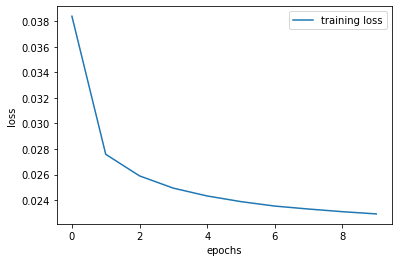

In [7]:
state_dict = torch.load("ae_weights.pth")
model.load_state_dict(state_dict)
plt.plot(train_losses,label="training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

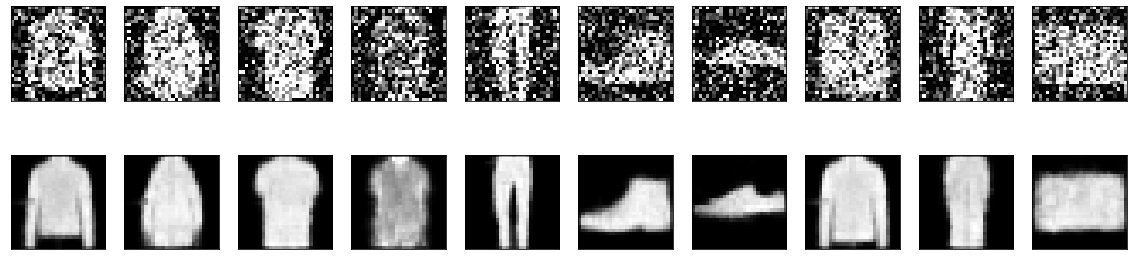

In [8]:
test_images, _ = next(iter(testloader))

noisy_imgs = test_images + 0.5 * torch.randn(*test_images.shape)
noisy_imgs = np.clip(noisy_imgs,0.,1.)

outputs = model(noisy_imgs)
outputs = outputs.view(outputs.shape[0],1,28,28)
outputs = outputs.detach().numpy()

fig,ax = plt.subplots(2,10,sharex=True,sharey=True,figsize=(20,5))

for noisy_imgs,row in zip([noisy_imgs,outputs],ax):
    for img,ax in zip(noisy_imgs,row):
        ax.imshow(img.squeeze(),cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

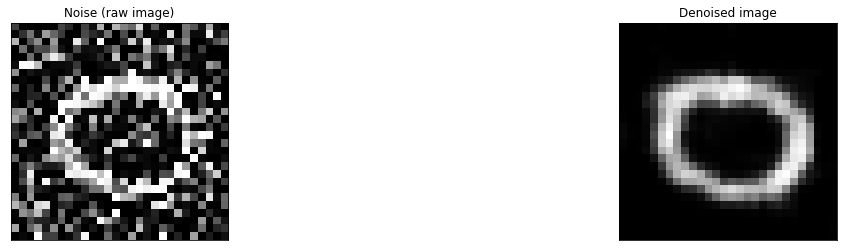

In [ ]:
## testing single image samples
import cv2

noisy_img = cv2.imread("test_img.jpg",0) # load noisy image in gray scale

noisy_img = transform(noisy_img)

noisy_img = torch.stack([noisy_img])
outputs = model(noisy_img)
outputs = outputs.view(outputs.shape[0],1,28,28)
outputs = outputs.detach().numpy()
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,2,1,xticks=[],yticks=[])
ax.imshow(noisy_img.squeeze(),cmap="gray")
ax.set_title("Noise (raw image)")
ax = fig.add_subplot(1,2,2,xticks=[],yticks=[])
ax.imshow(outputs.squeeze(),cmap="gray")
ax.set_title("Denoised image")
plt.show()